In [1]:
from gibbs import *

In [2]:
file_name = "gs_maxcut.txt"
file1 = open(file_name,"r")
first_line = file1.readline()[:-1].split("\t") # first line

all_files = []
for line in file1:
    arr = line[:-1].split("\t")
    all_files += [[int(elem) for elem in arr]]

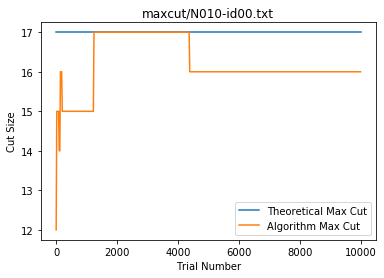

In [5]:
x = plot_max_cut_efficiency_discrete_rbm(0, 0, all_files, 10000, 20, 20)

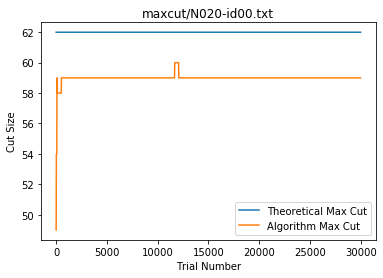

In [6]:
x = plot_max_cut_efficiency_discrete_rbm(1, 0, all_files, 30000, 20, 20)

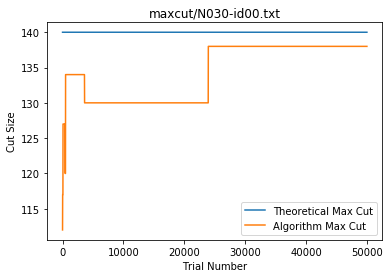

In [7]:
x = plot_max_cut_efficiency_discrete_rbm(2, 0, all_files, 50000, 20, 20)

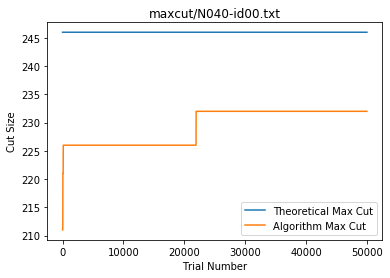

In [3]:
x = plot_max_cut_efficiency_discrete_rbm(3, 0, all_files, 50000, 20, 20)

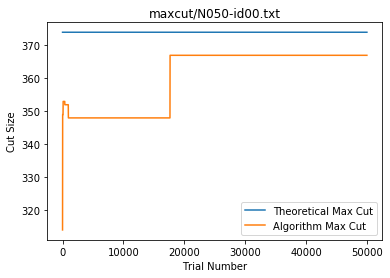

In [8]:
x = plot_max_cut_efficiency_discrete_rbm(4, 0, all_files, 50000, 20, 20)

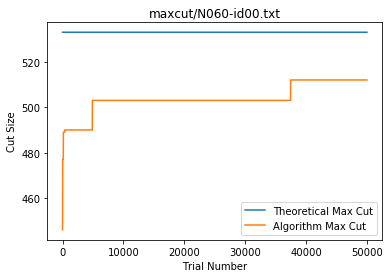

In [9]:
x = plot_max_cut_efficiency_discrete_rbm(5, 0, all_files, 50000, 20, 20)

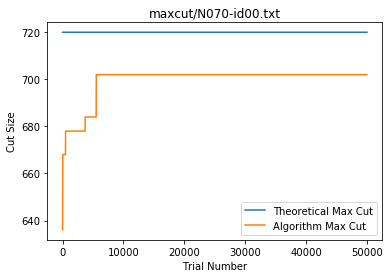

In [10]:
x = plot_max_cut_efficiency_discrete_rbm(6, 0, all_files, 50000, 20, 20)

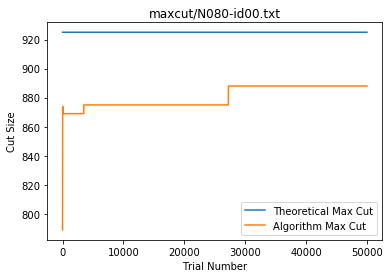

In [12]:
x = plot_max_cut_efficiency_discrete_rbm(7, 0, all_files, 50000, 20, 20)

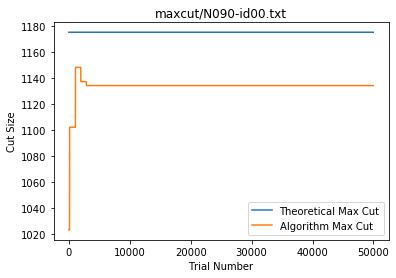

In [11]:
x = plot_max_cut_efficiency_discrete_rbm(8, 0, all_files, 50000, 20, 20)

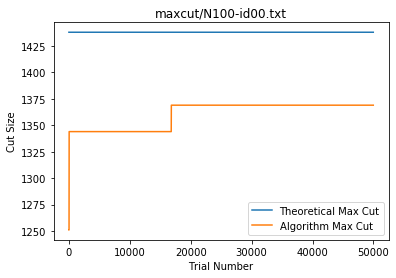

In [13]:
x = plot_max_cut_efficiency_discrete_rbm(9, 0, all_files, 50000, 20, 20)

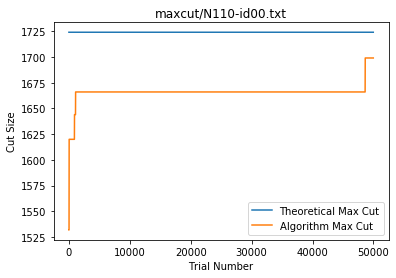

In [14]:
x = plot_max_cut_efficiency_discrete_rbm(10, 0, all_files, 50000, 20, 20)

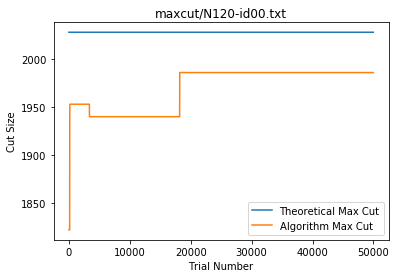

In [15]:
x = plot_max_cut_efficiency_discrete_rbm(11, 0, all_files, 50000, 20, 20)

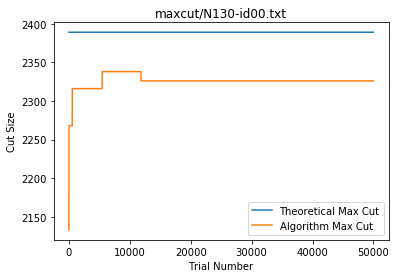

In [ ]:
x = plot_max_cut_efficiency_discrete_rbm(12, 0, all_files, 50000, 20, 20)

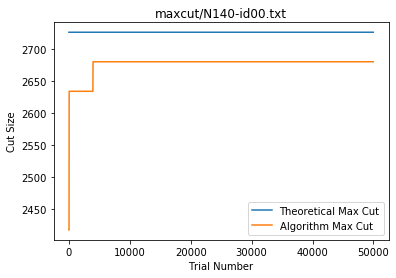

In [ ]:
x = plot_max_cut_efficiency_discrete_rbm(13, 0, all_files, 50000, 20, 20)

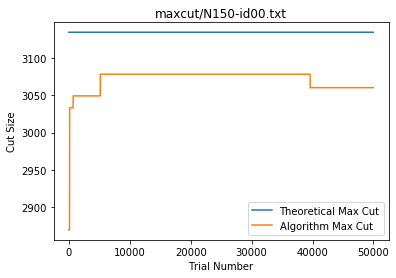

In [ ]:
x = plot_max_cut_efficiency_discrete_rbm(14, 0, all_files, 50000, 20, 20)